In [2]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("Movie.csv")
data.drop(columns=['original_language','vote_count','revenue','budget','id','production_companies','director_of_photography','writers','music_composer','overview','tagline','spoken_languages','production_countries', 'original_title', 'cast', 'director', 'producers' ], inplace=True)
#data.head()

In [3]:
data['release_date'] = pd.to_datetime(data['release_date'])

categorical_cols = ['status', 'genres', 'imdb_id']
for col in categorical_cols:
    data[col] = data[col].astype('category')

print(data.dtypes)

title                   object
vote_average           float64
status                category
release_date    datetime64[ns]
runtime                  int64
imdb_id               category
popularity             float64
genres                category
dtype: object


In [4]:
data['release_date'] = pd.to_datetime(data['release_date'])
data_after_2010 = data[data['release_date'].dt.year > 2010]
cutoff_date = pd.to_datetime('2024-08-31')
data = data_after_2010[data_after_2010['release_date'] <= cutoff_date]

#Keep only released, post production, and in production
desired_status = ['Released', 'Post Production', 'In Production']
data = data[data['status'].isin(desired_status)]

#drop nan
data = data.dropna(subset=['runtime'])  
data = data[data['runtime'] >= 40]
data = data.dropna(subset=['imdb_id'])
data = data.dropna(subset=['genres'])
data = data.dropna(subset=['title'])

data

,title,vote_average,status,release_date,runtime,imdb_id,popularity,genres
148,Sin City: A Dame to Kill For,6.369,Released,2014-08-20,102,tt0458481,43.479,"Crime, Action, Thriller"
1164,Captain America: The First Avenger,6.999,Released,2011-07-22,124,tt0458339,48.690,"Action, Adventure, Science Fiction"
1238,Pirates of the Caribbean: On Stranger Tides,6.500,Released,2011-05-15,137,tt1298650,159.056,"Adventure, Action, Fantasy"
1294,The Amazing Spider-Man,6.697,Released,2012-06-23,136,tt0948470,76.022,"Action, Adventure, Science Fiction"
2462,Scary Movie 5,4.810,Released,2013-04-11,86,tt0795461,39.538,Comedy
...,...,...,...,...,...,...,...,...
905075,My Special Secretary,0.000,Released,2015-03-14,79,tt30474956,0.755,Comedy
905241,Veppam Kulir Mazhai,0.000,Post Production,2024-03-29,132,tt31719063,0.000,Thriller
905354,Once Upon a Deadtime Story,0.000,Released,2015-11-13,143,tt4540966,0.000,Horror
905395,A Zulu Christmas,0.000,Released,2020-12-25,68,tt21025680,0.000,Drama


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Filter data from 2011 to 2015
filtered_data = data[(data['release_date'].dt.year >= 2011) & (data['release_date'].dt.year <= 2015)]

# Split genres into multiple binary columns
genres_split = filtered_data['genres'].str.get_dummies(sep=', ')

# Combine the new genre columns with other features
X = pd.concat([filtered_data[['vote_average', 'runtime']], genres_split], axis=1)
y = filtered_data['release_date'].dt.year

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.2071060626073174


In [6]:
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

pcatest = data

# Drop unnecessary columns
pcatest = pcatest.drop(['title', 'imdb_id', 'release_date'], axis=1)

# Encode categorical variables (if any)
pcatest = pd.get_dummies(pcatest, columns=['genres'])

# Convert categorical variables to numerical representations (if any)
pcatest['status'] = pcatest['status'].astype('category').cat.codes

# Initialize the IncrementalPCA with a desired number of components
n_components = 2  # Choose the number of components
ipca = IncrementalPCA(n_components=n_components)

# Standardize and transform the data in mini-batches
batch_size = 1000
for batch_start in range(0, len(pcatest), batch_size):
    batch_end = min(batch_start + batch_size, len(pcatest))
    pcatest_batch = pcatest.iloc[batch_start:batch_end]
    scaler = StandardScaler()
    pcatest_scaled = scaler.fit_transform(pcatest_batch)
    ipca.partial_fit(pcatest_scaled)

# Transform the entire dataset using IPCA
pcatest_transformed = ipca.transform(pcatest)

# Visualize the PCA result
plt.scatter(pcatest_transformed[:, 0], pcatest_transformed[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')
plt.show()


/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but IncrementalPCA was fitted without feature names
  warnings.warn(


MemoryError: Unable to allocate 11.1 GiB for an array with shape (13118, 113679) and data type float64

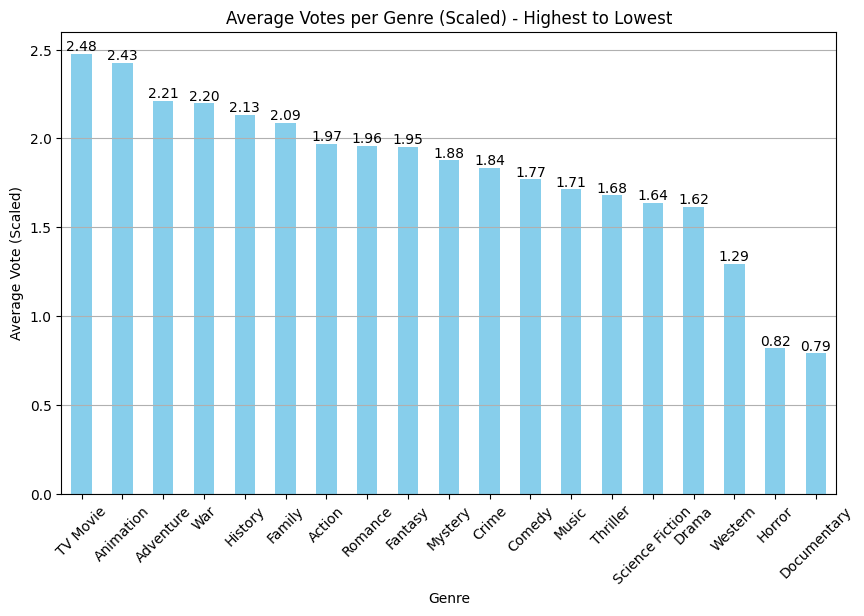

In [ ]:
data_genres = data.assign(genres=data['genres'].str.split(', ')).explode('genres').reset_index(drop=True)

avg_votes_per_genre = data_genres.groupby('genres')['vote_average'].mean()

avg_votes_per_genre_scaled = avg_votes_per_genre - 3.0

avg_votes_per_genre_scaled_sorted = avg_votes_per_genre_scaled.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
bars = avg_votes_per_genre_scaled_sorted.plot(kind='bar', color='skyblue')
plt.title('Average Votes per Genre (Scaled) - Highest to Lowest')
plt.xlabel('Genre')
plt.ylabel('Average Vote (Scaled)')
plt.xticks(rotation=45)
plt.grid(axis='y')

for bar in bars.patches:
    plt.annotate(format(bar.get_height(), '.2f'), 
                 (bar.get_x() + bar.get_width() / 2, 
                  bar.get_height()), 
                 ha='center', 
                 va='center', 
                 xytext=(0, 5), 
                 textcoords='offset points')

plt.show()


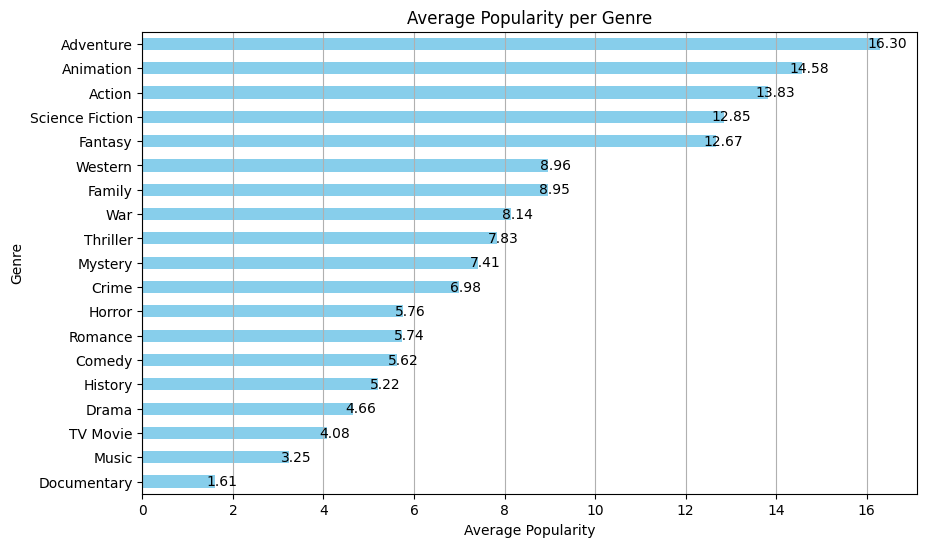

In [ ]:
data_genres = data.assign(genres=data['genres'].str.split(', ')).explode('genres').reset_index(drop=True)

avg_popularity_per_genre = data_genres.groupby('genres')['popularity'].mean()

avg_popularity_per_genre_sorted = avg_popularity_per_genre.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
bars = avg_popularity_per_genre_sorted.plot(kind='barh', color='skyblue')
plt.title('Average Popularity per Genre')
plt.xlabel('Average Popularity')
plt.ylabel('Genre')
plt.grid(axis='x')

for bar in bars.patches:
    plt.annotate(format(bar.get_width(), '.2f'), 
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2), 
                 ha='center', 
                 va='center', 
                 xytext=(5, 0), 
                 textcoords='offset points')

plt.show()


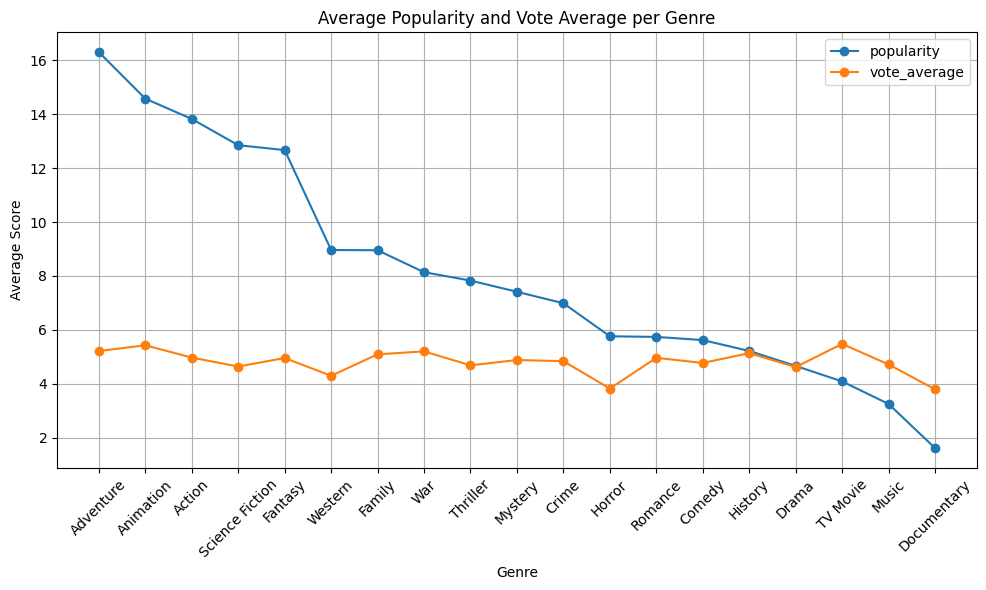

In [ ]:
data_genres = data.assign(genres=data['genres'].str.split(', ')).explode('genres')

genre_metrics = data_genres.groupby('genres')[['popularity', 'vote_average']].mean()

genre_metrics_sorted = genre_metrics.sort_values(by='popularity', ascending=False)

plt.figure(figsize=(10, 6))
for column in genre_metrics_sorted.columns:
    plt.plot(genre_metrics_sorted.index, genre_metrics_sorted[column], marker='o', label=column)

plt.title('Average Popularity and Vote Average per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_7473/4099164491.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  avg_popularity_6months = data.set_index('release_date').resample('6M')['popularity'].mean()


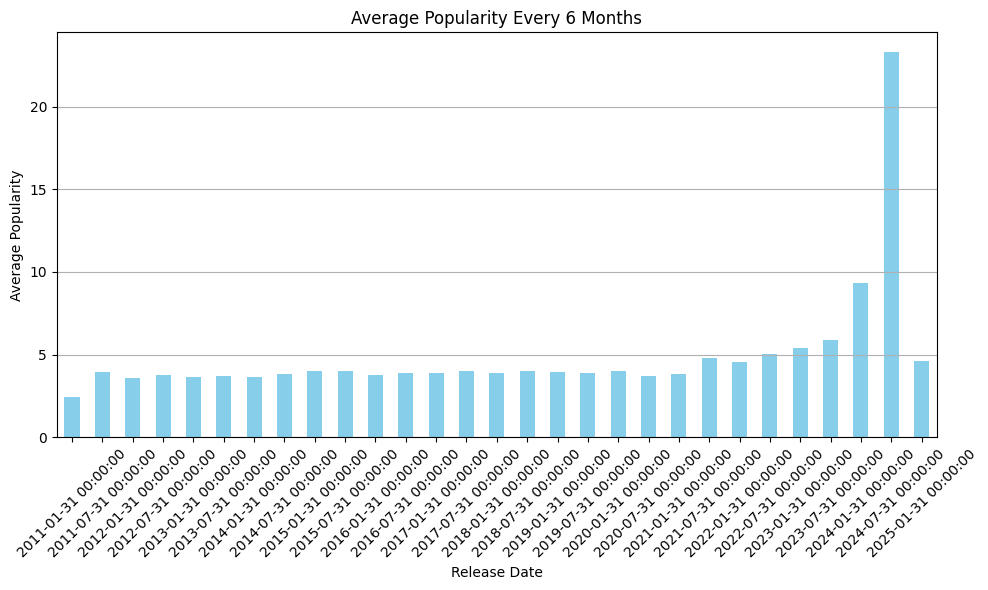

In [ ]:
data['release_date'] = pd.to_datetime(data['release_date'])

avg_popularity_6months = data.set_index('release_date').resample('6M')['popularity'].mean()

plt.figure(figsize=(10, 6))
avg_popularity_6months.plot(kind='bar', color='skyblue')

plt.title('Average Popularity Every 6 Months')
plt.xlabel('Release Date')
plt.ylabel('Average Popularity')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


We chose this diagram because it shows how popular certain movie types are in each continent. We wanted to visualize our data in a more effective manner by considering continents and the various genres of movies. We performed initial data cleaning, but further cleaning is still required. Our dataset was reduced from 900,000 rows to 120,000 rows. The main filtering criteria included selecting movies released after 2010 and before the end of summer 2024. Additionally, we removed unnecessary columns and filtered out NaN data, such as movies with a runtime of 0.